In [1]:
try:
    from google.colab import drive
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: using Google CoLab


In [2]:
if COLAB:
  !sudo apt-get install -y xvfb ffmpeg x11-utils
  !pip install -q 'gym==0.10.11'
  !pip install -q 'imageio==2.4.0'
  !pip install -q PILLOW
  !pip install -q 'pyglet==1.3.2'
  !pip install -q pyvirtualdisplay
  !pip install -q tf-agents

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 37 not upgraded.
Need to get 994 kB of archives.
After this operation, 2,981 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.9 [784 kB]
Fetched 994 kB in 1s (1,126 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 3.)
debconf: falling back t

In [22]:
import tf_agents
from tf_agents.environments import suite_gym
import PIL.Image
import pyvirtualdisplay

display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

env_name = 'MountainCar-v0'
env = suite_gym.load(env_name)
env.reset()
# PIL.Image.fromarray(env.render())

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-0.43189883,  0.        ], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})

In [6]:
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [15]:
import numpy as np

import gym
from gym import wrappers

n_states = 40
iter_max = 10000

initial_lr = 1.0 # Learning rate
min_lr = 0.003
gamma = 1.0
t_max = 10000
eps = 0.02

def run_episode(env, policy=None, render=False):
    obs = env.reset()
    total_reward = 0
    step_idx = 0
    for _ in range(t_max):
        if render:
            env.render()
        if policy is None:
            action = env.action_space.sample()
        else:
            a,b = obs_to_state(env, obs)
            action = policy[a][b]
        obs, reward, done, _ = env.step(action)
        total_reward += gamma ** step_idx * reward
        step_idx += 1
        if done:
            break
    return total_reward

def obs_to_state(env, obs):
    """ Maps an observation to state """
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    env_dx = (env_high - env_low) / n_states
    a = int((obs[0] - env_low[0])/env_dx[0])
    b = int((obs[1] - env_low[1])/env_dx[1])
    return a, b

In [23]:
env_name = 'MountainCar-v0'
env = gym.make(env_name)
env.seed(0)
np.random.seed(0)
reward_history = []
print ('----- using Q Learning -----')
q_table = np.zeros((n_states, n_states, 3))
for i in range(iter_max):
    obs = env.reset()
    total_reward = 0
        ## eta: learning rate is decreased at each step
    eta = max(min_lr, initial_lr * (0.85 ** (i//100)))
    for j in range(t_max):
        a, b = obs_to_state(env, obs)
        if np.random.uniform(0, 1) < eps:
            action = np.random.choice(env.action_space.n)
        else:
            logits = q_table[a][b]
            logits_exp = np.exp(logits)
            probs = logits_exp / np.sum(logits_exp)
            action = np.random.choice(env.action_space.n, p=probs)
        obs, reward, done, _ = env.step(action)
        total_reward += (gamma ** j) * reward
            # update q table
        a_, b_ = obs_to_state(env, obs)
        q_table[a][b][action] = q_table[a][b][action] + eta * (reward + gamma *  np.max(q_table[a_][b_]) - q_table[a][b][action])
        if done:
            break
    reward_history.append(total_reward)
    if i % 100 == 0:
        print('Iteration #%d -- Total reward = %d.' %(i+1, total_reward))
solution_policy = np.argmax(q_table, axis=2)
solution_policy_scores = [run_episode(env, solution_policy, False) for _ in range(100)]
print("Average score of solution = ", np.mean(solution_policy_scores))
    # Animate it
run_episode(env, solution_policy, True)

----- using Q Learning -----
Iteration #1 -- Total reward = -200.
Iteration #101 -- Total reward = -200.
Iteration #201 -- Total reward = -200.
Iteration #301 -- Total reward = -200.
Iteration #401 -- Total reward = -200.
Iteration #501 -- Total reward = -200.
Iteration #601 -- Total reward = -200.
Iteration #701 -- Total reward = -200.
Iteration #801 -- Total reward = -200.
Iteration #901 -- Total reward = -200.
Iteration #1001 -- Total reward = -200.
Iteration #1101 -- Total reward = -200.
Iteration #1201 -- Total reward = -200.
Iteration #1301 -- Total reward = -200.
Iteration #1401 -- Total reward = -200.
Iteration #1501 -- Total reward = -200.
Iteration #1601 -- Total reward = -178.
Iteration #1701 -- Total reward = -200.
Iteration #1801 -- Total reward = -200.
Iteration #1901 -- Total reward = -200.
Iteration #2001 -- Total reward = -200.
Iteration #2101 -- Total reward = -200.
Iteration #2201 -- Total reward = -200.
Iteration #2301 -- Total reward = -200.
Iteration #2401 -- Tota

-157.0

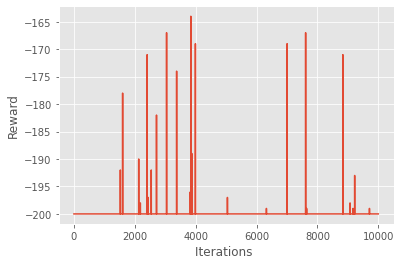

In [25]:
plt.plot(reward_history)
plt.xlabel('Iterations ')
plt.ylabel('Reward')
plt.savefig('Reward_plot_Qlearning.png')

In [26]:
import os 
os.getcwd()

'/content'